# CA2 - Data Preparation and Visualization on Agriculture Datasets

## Overview

In this notebook, the following agriculture related datasets were pre-processed to be used by the Machine Learning (ML) and Statistics Jupyter notebooks.

- Organic Farming
- Agriculture Import/Export Trade
- Food Price Inflation
- Tweets Dataset

## Auxiliary Functions

In this section, the auxiliary functions used in this notebook were implemented.

In [1]:
# adding modules folder to the path
import sys
sys.path.append('./modules')

# importing constants and modules created for this project
from constants import *
from text_processor import *
from twitter_api import *

# uncomment to install any missing lib
# !pip install python-dotenv

# importing modules specific to this notebook
import logging
import pandas as pd
import altair as alt
import seaborn as sns
from dotenv import dotenv_values
from os import listdir

# use a logger to help debugging
logger = logging.getLogger('data_prep_vis')

# set logger level
logger.setLevel(logging.ERROR)

def convert_to_number(df, col_list=[]):
    """
    This function converts the column in the list into
    numeric data type.

    Parameters:
        df: Data frame with original data.
        col_list: List of column names to be converted.
    Return:
        Updated dataframe.
    """         
    for c in col_list:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

def plot_interactive_graph(data, dropdown=[], y_label='', main_title=''):
    """
    This function uses altair lib to plot interactive graph based on the input.
    
    Parameters:
        data: Data frame
        dropdown: List of items to filter the data displayed in the graph
        y_label: Y label text
        main_title: Title of the graph
    """
    input_dropdown = alt.binding_select(options=dropdown, name='Item')

    select_item = alt.selection_single(
        name='Select Import Item', fields=['Item'], init={'Item': dropdown[0]},
        bind=input_dropdown)

    alt.Chart(data, title=main_title).mark_point(filled=True).encode(
        alt.X('Year', scale=alt.Scale(zero=False)),
        alt.Y('Value', scale=alt.Scale(zero=False), title=y_label),
        alt.Size('Value:Q'),
        alt.Color('Area:N'),
        alt.Order('Value:Q', sort='descending'),
        tooltip='Value:N'
    ).add_selection(select_item).transform_filter(select_item).display()

def get_env_map():
    """
    Auxiliary function to read and parse the environment file for the Twitter API.
    
    It assumes an env file exists in the home dir.

    Returns:
        env (dict): Dictionary with the env parameters.
    """
    env_path = join(HOME_DIR, TWITTER_ENV_FILE)

    if not os.path.exists(env_path):
        logger.error(F'Unable to read the environment file. Make sure a { TWITTER_ENV_FILE } file exists in your home directory.')
        return None

    return dotenv_values(env_path)

def process_tweets(tweets_list):
    """
    Auxiliary method to process the tweets from the input list.
    
    It processes the tweets, extracting their sentiment during the process.
    
    It generates a table with the following columns:

        'tweet_raw', 'sent_raw', 'tweet_clr', 'sent_clr', 'tweet_st', 'sent_st', 'tweet_lm', 'sent_lm'
    
    Parameters:
        tweets_list (lst): List of tweets to be processed.
    Returns:
        tweets_df (DataFrame): Data frame with the processed data.
    """
    proc_tweets = []
    for i in range(0, len(tweets_list)):
        # raw tweet
        tweet_raw = tweets_list[i]
        sentiment_raw = TextProcessor.get_sentiment(tweet_raw)

        # strip tweet
        tweet_str = TextProcessor.clean_text(tweet_raw)
        sentiment_str = TextProcessor.get_sentiment(tweet_str)
        
        # cleaned tweet
        tweet_clr = TextProcessor.process_text(tweet_raw)
        sentiment_clr = TextProcessor.get_sentiment(tweet_clr)

        # steemed tweet
        tweet_st = TextProcessor.process_text(tweet_raw, use_stemmer=True)
        sentiment_st = TextProcessor.get_sentiment(tweet_st)

        # lemmatized tweet
        tweet_lm = TextProcessor.process_text(tweet_raw, use_lemmatizer=True)
        sentiment_lm = TextProcessor.get_sentiment(tweet_lm)

        proc_tweets.append((tweet_raw, sentiment_raw, tweet_str, sentiment_str, tweet_clr, sentiment_clr, tweet_st, sentiment_st, tweet_lm, sentiment_lm))

    tweets_df = pd.DataFrame(proc_tweets, columns=['tweet_raw', 'sent_raw', 'tweet_str', 'sent_str', 'tweet_clr', 'sent_clr', 'tweet_st', 'sent_st', 'tweet_lm', 'sent_lm'])

    return tweets_df

def get_collected_twitter_file_path():
    """
    Auxiliary function to get a valid twitter file name.
    
    It checks if there is a file with the same name and append an index.

    Returns:
        filename (str): Available filename.
    """    
    same_file_list = [f for f in listdir(TWEETS_DIR) if isfile(join(TWEETS_DIR, f)) 
                      and str(f).startswith(TWEETS_DF_FILE) and str(f).endswith('.csv')]
    n_same_file = len(same_file_list)

    suffix = ''
    if n_same_file > 0:
        suffix = f'_{ n_same_file }'

    filename = f'{TWEETS_DF_FILE}{ suffix }.csv'
    return join(TWEETS_DIR, filename)


## Organic Farming

In this section, the organic farming dataset was cleand and prepared for the analysis performed in the Statistics Jupyter notebook.

In [2]:
# showing raw dataset
dataset = pd.read_csv(join(DATASETS_FOLDER, ORG_FARM_DATASET), encoding='utf-8')
dataset.head()

,GEO (Codes),GEO (Labels),2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,EU,"European Union (EU6-1958, EU9-1973, EU10-1981,...",3.0,:,3.8,4.0,:,3.8,4.1,4.0,...,5.4,5.66,5.70,5.78,6.20,6.68,7.03,7.50,7.92,9.08
1,EU27_2020,European Union - 27 countries (from 2020),:,:,:,:,:,:,:,:,...,:,5.88,5.91,6.08,6.56,7.09,7.48,8.03,8.49,9.08
2,EU28,European Union - 28 countries (2013-2020),:,:,:,:,:,:,:,:,...,:,5.64,5.70,5.78,6.20,6.68,7.03,7.50,7.92,:
3,BE,Belgium,1.5,1.6,2.1,1.7,1.7,1.7,2.1,2.4,...,4.1,4.48,4.67,5.00,5.17,5.80,6.28,6.56,6.85,7.25
4,BG,Bulgaria,:,:,:,:,:,0.2,0.1,0.3,...,0.5,0.76,1.13,0.96,2.37,3.20,2.72,2.56,2.34,2.30


The raw dataset was cleaned to remove unnecessary columns and to convert the percent data into numeric data type. 

That step was necessary to fit the dataset into the functions used to calculate the confidence interval as part of the statistical analysis.

The main idea of the analysis performed about this dataset was to compare Ireland's organic farming growht with the estimated confidence interval for Europe.

This way, it was also created two datasets out of it, one with the all countries and another one with Ireland's data only.

In [3]:
# keeping only specific countries data
codes_col = dataset.keys()[0]
dataset_all = dataset.loc[~dataset[codes_col].str.contains('EU')]

# getting Ireland's data only
dataset_ire = dataset.loc[dataset[codes_col] =='IE']

# removing first two columns with labels
dataset_all = dataset.iloc[:,2:]
dataset_ire = dataset_ire.iloc[:,2:]

# converting data into numbers
columns = dataset_all.keys()
dataset_all = convert_to_number(dataset_all, columns)
dataset_ire = convert_to_number(dataset_ire, columns)

In [4]:
# show dataset all head
dataset_all.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,3.0,NaN,3.8,4.0,NaN,3.8,4.1,4.0,4.3,4.7,...,5.4,5.66,5.70,5.78,6.20,6.68,7.03,7.50,7.92,9.08
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.88,5.91,6.08,6.56,7.09,7.48,8.03,8.49,9.08
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.64,5.70,5.78,6.20,6.68,7.03,7.50,7.92,NaN
3,1.5,1.6,2.1,1.7,1.7,1.7,2.1,2.4,2.6,3.0,...,4.1,4.48,4.67,5.00,5.17,5.80,6.28,6.56,6.85,7.25
4,NaN,NaN,NaN,NaN,NaN,0.2,0.1,0.3,0.3,0.2,...,0.5,0.76,1.13,0.96,2.37,3.20,2.72,2.56,2.34,2.30


In [5]:
# show dataset ireland head
dataset_ire.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
9,0.6,0.7,0.7,0.7,0.7,0.8,0.9,1,1,1.1,...,1.1,1.16,1.2,1.16,1.65,1.72,1.66,1.65,1.63,1.66


The command below shows the dataset has null values spread all over the rows.

Since each country has nulls in different rows they can't be simply removed at this point, so they should be handled in the analysis.

In [6]:
# checking empty values on full dataset
dataset_all.isnull().sum()

2000    20
2001    21
2002    19
2003    16
2004    11
2005     7
2006     8
2007     8
2008     8
2009     8
2010     9
2011     9
2012     4
2013     1
2014     1
2015     0
2016     1
2017     0
2018     1
2019     0
2020     2
dtype: int64

In [7]:
# checking empty values on ireland dataset
dataset_ire.isnull().sum()

2000    0
2001    0
2002    0
2003    0
2004    0
2005    0
2006    0
2007    0
2008    0
2009    0
2010    0
2011    0
2012    0
2013    0
2014    0
2015    0
2016    0
2017    0
2018    0
2019    0
2020    0
dtype: int64

The cleaned datasets were stored in the output folder to be used by other notebooks.

In [8]:
# creating a csv file in the output folder for the full dataset
dataset_all.to_csv(join(DATA_PREP_FOLDER, ORG_FARM_DATASET), index=False)

# creating a csv file in the output folder for the irish dataset
dataset_ire.to_csv(join(DATA_PREP_FOLDER, ORG_FARM_DATASET_IRE), index=False)

## Agriculture Import/Export Trade

In this section, the agriculture import/export trade dataset was cleand and prepared for the analysis performed in the Statistics and ML Jupyter notebooks.

In [9]:
# showing raw dataset
dataset = pd.read_csv(join(DATASETS_FOLDER, IMP_EXP_DATASET), encoding='utf-8')
dataset.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1961,1961,tonnes,95.0,A,Official figure
1,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1962,1962,tonnes,32.0,A,Official figure
2,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1963,1963,tonnes,115.0,A,Official figure
3,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1964,1964,tonnes,49.0,A,Official figure
4,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1965,1965,tonnes,42.0,A,Official figure


The first step was the null check, which showed there is no null values in this dataset.

In [10]:
# checking empty values on full dataset
dataset.isnull().sum()

Domain Code         0
Domain              0
Area Code (M49)     0
Area                0
Element Code        0
Element             0
Item Code (CPC)     0
Item                0
Year Code           0
Year                0
Unit                0
Value               0
Flag                0
Flag Description    0
dtype: int64

Now, the Value's column data were converted into numeric data type to comply with the Python functions used.

In [11]:
# converting Value column into numeric data type
dataset = convert_to_number(dataset, ['Value'])
dataset.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1961,1961,tonnes,95.0,A,Official figure
1,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1962,1962,tonnes,32.0,A,Official figure
2,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1963,1963,tonnes,115.0,A,Official figure
3,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1964,1964,tonnes,49.0,A,Official figure
4,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1965,1965,tonnes,42.0,A,Official figure


The main idea of the analysis performed about this dataset was to compare the countries import/export data with Ireland.

Thus, the data was split into import/export quantity (data in tonnes) and import/export value (data in US$) datasets to facilitate data manipulation.

In [12]:
# checking the Element values
list(dataset['Element'].unique())

['Import Quantity', 'Import Value', 'Export Quantity', 'Export Value']

In [13]:
# splitting data into import/export value and quantity
im_ex_val_data = dataset[(dataset['Element'].isin(['Import Value', 'Export Value']))]
im_ex_qtt_data = dataset[(dataset['Element'].isin(['Import Quantity', 'Export Quantity']))]

After splitting the datasets, it was checked the Unit column so that data is compared against the same measurement unit.

In [14]:
# checking unit for import/export quantity data
print(im_ex_val_data['Unit'].unique())
print(im_ex_qtt_data['Unit'].unique())

['1000 US$']
['tonnes' 'Head' 'No' '1000 Head']


Import/Export value is measured in 1000 US$, so no need to change anything here. 

On the other hand, the Import/Export quantity data were collected using different units: ['tonnes' 'Head' 'No' '1000 Head'].

As shown in the command below, most of the rows is measured in Tonnes, so the other units were removed to avoid mixing up unrelated data.

In [15]:
im_ex_qtt_data['Unit'].describe()

count      97496
unique         4
top       tonnes
freq       94961
Name: Unit, dtype: object

In [16]:
# since tonnes is the most frequent unit, remove the other ones
im_ex_qtt_data = im_ex_qtt_data[im_ex_qtt_data['Unit'] == 'tonnes']
im_ex_qtt_data.shape

(94961, 14)

The cleaned datasets were stored in the output folder to be used by other notebooks.

In [17]:
# creating a csv file in the output folder for the full dataset
im_ex_val_data.to_csv(join(DATA_PREP_FOLDER, IMP_EXP_DATASET_VAL), index=False)

# creating a csv file in the output folder for the irish dataset
im_ex_qtt_data.to_csv(join(DATA_PREP_FOLDER, IMP_EXP_DATASET_QTT), index=False)

In this step, the import/export data were summarized by year per country and the graphs were generated. 

The idea was to have a visual way to demonstrate the statistical results in the Statistics Jupyter notebook.

The graphs were also saved in the images folder as they are used by other notebooks.

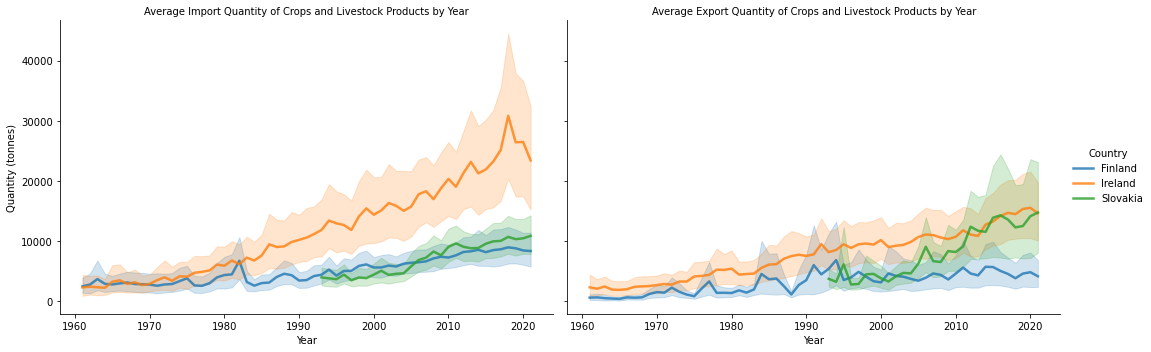

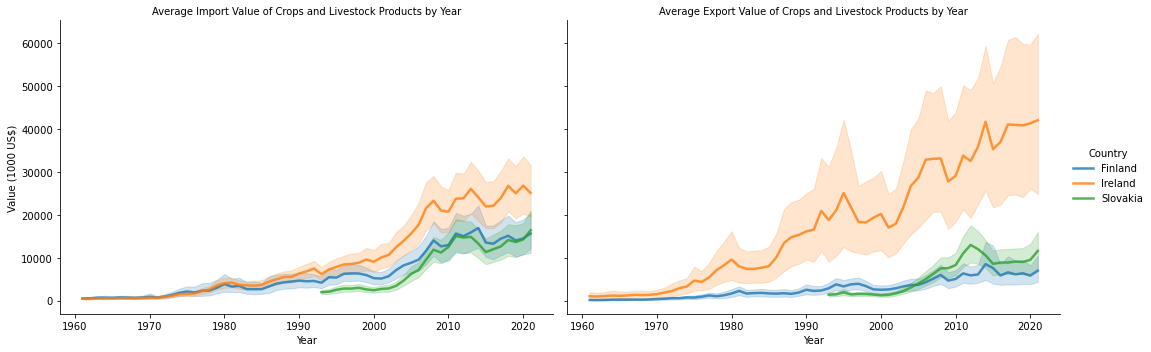

In [18]:
# adding the datasets into a list to facilitate graph generation
datasets = [im_ex_qtt_data, im_ex_val_data]

# graph file names
graph_fnames = [GRAPH_IMP_EXP_QTT, GRAPH_IMP_EXP_VAL]

# y labels to be displayed
y_labels = ['Quantity (tonnes)', 'Value (1000 US$)']

# counter to access the arrays
idx = 0

# create the graph for each dataset (quantity and value)
for data in datasets:
    # create the grid to display the import and export data
    im_exp_grid = sns.FacetGrid(data, col='Element', hue='Area', height=5, aspect=1.5)

    # map the above form facetgrid with some attributes
    im_exp_grid.map(sns.lineplot, "Year", "Value", alpha=.8, linewidth=2.5)

    # adding legend
    im_exp_grid.add_legend(title='Country')
    
    # setting labels and titles
    im_exp_grid.set_xlabels('Year')
    im_exp_grid.set_ylabels(y_labels[idx])
    im_exp_grid.set_titles('Average {col_name} of Crops and Livestock Products by Year')

    # save graph as an image
    im_exp_grid.savefig(join(IMAGES_FOLDER, graph_fnames[idx]), format='png')
    
    # next iteration
    idx+=1

In this step, another visualization tool was created for this dataset, which shows the top 10 most imported products values and quantity in Ireland compared with other countries.

The reason for limitting the data was a limitation in the Altair lib that can't handle more than 5k rows and to facilitate data reading.

In [19]:
# getting import data only (quantity and value)
import_qtt_data = im_ex_qtt_data[im_ex_qtt_data['Element'] == 'Import Quantity']
import_val_data = im_ex_val_data[im_ex_val_data['Element'] == 'Import Value']

# getting the top 10 import items in terms of quantity in Ireland
top_10_items_ire = import_qtt_data[(import_qtt_data['Area'] == 'Ireland')].groupby(by='Item', as_index=False).mean().sort_values(by=['Value'], ascending=False, ignore_index=True).head(10)
top_10_items_ire = list(top_10_items_ire['Item'].unique())

print('Top 10 most imported products in Ireland (quantity):')
top_10_items_ire

Top 10 most imported products in Ireland (quantity):


['Maize (corn)',
 'Wheat',
 'Cake of  soya beans',
 'Food wastes',
 'Molasses',
 'Raw milk of cattle',
 'Brewing or distilling dregs and waste',
 'Other non-alcoholic caloric beverages',
 'Bran of wheat',
 'Gluten feed and meal']

After getting the top 10 list, the data on these products were extracted from the datasets.

In [20]:
# getting the quantity data on the top 10 items
top_10_items_data_qtt = import_qtt_data[import_qtt_data['Item'].isin(top_10_items_ire)]
top_10_items_data_qtt.sort_values(by=['Value'], ascending=False, ignore_index=True)

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,TCL,Crops and livestock products,372,Ireland,5610,Import Quantity,0112,Maize (corn),2018,2018,tonnes,1601643.39,A,Official figure
1,TCL,Crops and livestock products,372,Ireland,5610,Import Quantity,0112,Maize (corn),2019,2019,tonnes,1539355.99,A,Official figure
2,TCL,Crops and livestock products,372,Ireland,5610,Import Quantity,0112,Maize (corn),2020,2020,tonnes,1313413.75,A,Official figure
3,TCL,Crops and livestock products,372,Ireland,5610,Import Quantity,0112,Maize (corn),2021,2021,tonnes,1219959.29,A,Official figure
4,TCL,Crops and livestock products,372,Ireland,5610,Import Quantity,0112,Maize (corn),2017,2017,tonnes,1119412.15,A,Official figure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,TCL,Crops and livestock products,703,Slovakia,5610,Import Quantity,39160,Brewing or distilling dregs and waste,2002,2002,tonnes,0.00,E,Estimated value
1506,TCL,Crops and livestock products,703,Slovakia,5610,Import Quantity,39160,Brewing or distilling dregs and waste,2001,2001,tonnes,0.00,A,Official figure
1507,TCL,Crops and livestock products,372,Ireland,5610,Import Quantity,39160,Brewing or distilling dregs and waste,1972,1972,tonnes,0.00,A,Official figure
1508,TCL,Crops and livestock products,703,Slovakia,5610,Import Quantity,23540,Molasses,1996,1996,tonnes,0.00,T,Unofficial figure


In [21]:
# getting the value data on the top 10 items
top_10_items_data_val = import_val_data[import_val_data['Item'].isin(top_10_items_ire)]
top_10_items_data_val.sort_values(by=['Value'], ascending=False, ignore_index=True)

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,TCL,Crops and livestock products,372,Ireland,5622,Import Value,24490,Other non-alcoholic caloric beverages,2021,2021,1000 US$,340205.0,A,Official figure
1,TCL,Crops and livestock products,372,Ireland,5622,Import Value,24490,Other non-alcoholic caloric beverages,2008,2008,1000 US$,338670.0,A,Official figure
2,TCL,Crops and livestock products,372,Ireland,5622,Import Value,0112,Maize (corn),2021,2021,1000 US$,328511.0,A,Official figure
3,TCL,Crops and livestock products,372,Ireland,5622,Import Value,0112,Maize (corn),2018,2018,1000 US$,322647.0,A,Official figure
4,TCL,Crops and livestock products,372,Ireland,5622,Import Value,39170.01,Food wastes,2018,2018,1000 US$,320887.0,A,Official figure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,TCL,Crops and livestock products,246,Finland,5622,Import Value,39160,Brewing or distilling dregs and waste,1983,1983,1000 US$,0.0,A,Official figure
1506,TCL,Crops and livestock products,246,Finland,5622,Import Value,39160,Brewing or distilling dregs and waste,1982,1982,1000 US$,0.0,A,Official figure
1507,TCL,Crops and livestock products,246,Finland,5622,Import Value,39160,Brewing or distilling dregs and waste,1981,1981,1000 US$,0.0,A,Official figure
1508,TCL,Crops and livestock products,246,Finland,5622,Import Value,39160,Brewing or distilling dregs and waste,1980,1980,1000 US$,0.0,A,Official figure


These datasets were also stored in the output folder to be used by other notebooks.

In [22]:
# creating a csv file in the output folder for the top 10 items quantity dataset
top_10_items_data_val.to_csv(join(DATA_PREP_FOLDER, IMP_EXP_DATASET_TOP10_VAL), index=False)

# creating a csv file in the output folder for the top 10 items value dataset
top_10_items_data_qtt.to_csv(join(DATA_PREP_FOLDER, IMP_EXP_DATASET_TOP10_QTT), index=False)

An interactive graph was created on the top 10 import products in Ireland and other countries.

In [23]:
# plotting an interactive graph with the quantity of the top import products
plot_interactive_graph(top_10_items_data_qtt, top_10_items_ire, 'Quantity (tonnes)', 'Top 10 most imported crops and livestock products in Ireland compared with other countries (Quantity in Tonnes)')

# plotting an interactive graph with the value of the top import products
plot_interactive_graph(top_10_items_data_val, top_10_items_ire, 'Value (1000 US$)', 'Top 10 most imported crops and livestock products in Ireland compared with other countries (Value in 1000 US$)')

alt.Chart(...)

alt.Chart(...)

In summary, the main reason to plot these graphs were to provide a good visual idea about the behaviour of the data in different levels, which helped to explain the statistics results discussed in the Statistics Jupyter notebook.

The interactive view also provides an easy way to show different products in the same graph

## Food Price Inflation

In this section, the agriculture dataset on food price inflation was cleand and prepared for the analysis performed in the Statistics and ML Jupyter notebooks.

In [24]:
# showing raw dataset
dataset = pd.read_csv(join(DATASETS_FOLDER, FOOD_INF_DATASET), encoding='utf-8')
dataset.head()

,Domain Code,Domain,Area Code (M49),Area,Year Code,Year,Item Code,Item,Months Code,Months,Unit,Value,Flag,Flag Description,Note
0,CP,Consumer Price Indices,246,Finland,2001,2001,23014,Food price inflation,7001,January,%,3.900862,E,Estimated value,NaN
1,CP,Consumer Price Indices,246,Finland,2001,2001,23014,Food price inflation,7002,February,%,2.525304,E,Estimated value,NaN
2,CP,Consumer Price Indices,246,Finland,2001,2001,23014,Food price inflation,7003,March,%,2.998384,E,Estimated value,NaN
3,CP,Consumer Price Indices,246,Finland,2001,2001,23014,Food price inflation,7004,April,%,2.810568,E,Estimated value,NaN
4,CP,Consumer Price Indices,246,Finland,2001,2001,23014,Food price inflation,7005,May,%,4.679704,E,Estimated value,NaN


In this step a summary of the dataset is displayed, which shows a null column.

In [25]:
# showing a summary of the dataset
dataset.describe()

,Area Code (M49),Year Code,Year,Item Code,Months Code,Value,Note
count,783.000000,783.000000,783.000000,783.0,783.000000,783.000000,0.0
mean,440.333333,2011.379310,2011.379310,23014.0,7006.448276,1.793597,NaN
std,192.848091,6.283411,6.283411,0.0,3.438844,3.791925,NaN
min,246.000000,2001.000000,2001.000000,23014.0,7001.000000,-8.216785,NaN
25%,246.000000,2006.000000,2006.000000,23014.0,7003.000000,-0.764112,NaN
50%,372.000000,2011.000000,2011.000000,23014.0,7006.000000,1.376673,NaN
75%,703.000000,2017.000000,2017.000000,23014.0,7009.000000,4.179901,NaN
max,703.000000,2022.000000,2022.000000,23014.0,7012.000000,23.280147,NaN


In this step, the data is cleansed for the inferential tests. The only operation was to remove an all-null column.

In [26]:
# remove null column from dataset
dataset = dataset.drop(['Note'], axis=1)

This dataset was also stored in the output folder to be used by other notebooks.

In [27]:
# creating a csv file in the output folder for the food inflation dataset
dataset.to_csv(join(DATA_PREP_FOLDER, FOOD_INF_DATASET), index=False)

The graph below shows the summarized food price inflation per country by year.

This way, it is possible to visualize the differences between the countries over the years, which helped to explain the results of the analysis in the other notebooks.

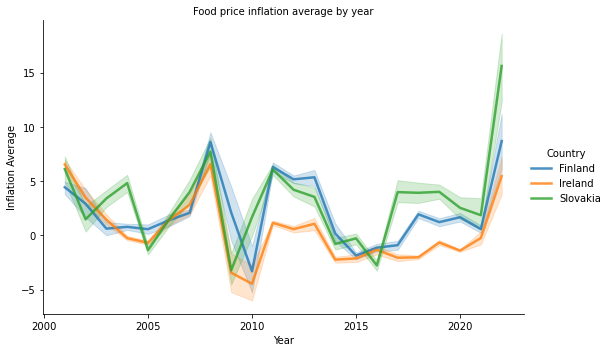

In [28]:
# create the grid to display the import and export data
food_inf_grid = sns.FacetGrid(dataset, col='Item', hue='Area', height=5, aspect=1.5)

# map the above form facetgrid with some attributes
food_inf_grid.map(sns.lineplot, "Year", "Value", alpha=.8, linewidth=2.5)

# adding legend
food_inf_grid.add_legend(title='Country')

# setting labels and titles
food_inf_grid.set_xlabels('Year')
food_inf_grid.set_ylabels('Inflation Average')
food_inf_grid.set_titles('{col_name} average by year')

# save graph as an image
food_inf_grid.savefig(join(IMAGES_FOLDER, GRAPH_FOOD_PRICE_INF), format='png')

The food inflation average was also calculated, since it is used by other notebooks.

In [29]:
# group inflation by year to get consolidated data
food_inf_avg = dataset.groupby(by=['Year', 'Area'], as_index=False).mean().sort_values(by=['Year'], ignore_index=True)

This dataset was stored in the output folder to be used by other notebooks.

In [30]:
# creating a csv file in the output folder for the food inflation average dataset
food_inf_avg.to_csv(join(DATA_PREP_FOLDER, FOOD_INF_DATASET_AVG), index=False)

## Twitter Dataset

In this section, it was implemented the logic to retrieve recent tweets using the Twitter API.

The idea was to collect tweets about agriculture for ML algorithms. 

More specifcally, the data was collected for sentiment analysis and classification.

Thus, the data preparation steps involved retrieving the data, applying specific text processing strategies and generating the csvs.

The operations performed to generated this dataset were:

1. Get the raw tweets using the API

2. Clean the tweets and save the output using the following strategies:
    1. Remove special characters, links and images (tweet_str)
    2. Apply strategy A + Remove stop words (tweet_clr)
    3. Apply strategy B + Apply Lemmatizer technique (tweet_lm)
    4. Apply strategy B + Apply Stemmer techinique (tweet_st)

3. Extract the sentment from each version of the tweets

4. Save data in a dataframe.

Each version of the tweet (i.e., tweet_str, tweet_clr, tweet_st and tweet_lm) has its own sentiment calculated, because it was observed that the sentiment algorithm provides different results for each of them. The possible sentiments are: positive, negative and neutral.

The output of this data preparation was consumed by the ML Jupyter notebook.

<b>Notice:</b>

<b>Using Twitter's API</b>

User should have an account on <a href="https://developer.twitter.com/https://developer.twitter.com/">Twitter's Developer Portal</a> to obtain their own access keys and tokens.
    
- The required access level to run the commands in this notebook is 'Essential'.

- There should exist a file called .twitter_env in the machine's home directory with the following API user keys:
    ```
    API_KEY=***
    API_KEY_SECRET=***
    BEARER_TOKEN=***
    ```

<b>Replacing Tweets Dataset</b>

Since the recent tweets can change over time, the analysis was performed on a previously collected dataset stored in ./datasets/tapi-agri-tweets.csv.

This way, if the user wants to use a fresh tweets list, they should do the following:

1. Comment out line 22 in the code block below
2. Run the code block below
3. Copy the csv just created from the ./datasets/tweets-online folder
4. Paste it into the ./datasets folder
5. Remove the old tweets csv file
6. Rename the new one to 'tapi-agri-tweets.csv'

In [31]:
# getting an instance of the twitter api
twitter_api = TwitterApi(get_env_map())

# defining the query parameters
query_params = {
    'query' : '(inflation OR "food price" OR "agriculture") Europe -is:retweet -has:media lang:en',
    'tweet.fields': 'author_id', 
    'user.fields': 'name',
    'max_results': '100'
}

# retrieving tweets according to the query
tweets_list = twitter_api.search_tweets(query_params)

# processing retrieved data using text processing
tweets_df = process_tweets(tweets_list)

# storing the processed data in the datasets/tweets-online folder
tweets_df.to_csv(get_collected_twitter_file_path())

# COMMENT THIS LINE IF NEW TWEETS ARE MEANT TO BE USED INSTEAD
tweets_df = pd.read_csv(join(DATASETS_FOLDER, TWEETS_DATASET))

# showing the tweets
tweets_df.head()

200 tweets retrieved!


,tweet_raw,sent_raw,tweet_clr,sent_clr,tweet_st,sent_st,tweet_lm,sent_lm,tweet_str,sent_str
0,British public were treated like mugs..lied to...,negative,british public treated like mugs lied sold riv...,neutral,british public treat like mug lie sold river p...,positive,british public treated like mugs lied sold riv...,positive,british public were treated like mugs lied to...,negative
1,EU economies set to contract in 2023 - Financi...,positive,eu economies set contract financial times acco...,positive,eu economi set contract financi time accord ex...,positive,eu economies set contract financial times acco...,positive,eu economies set to contract in financi...,positive
2,Big big good news for all #Europe and #USA in ...,negative,big big good news europe usa cold season natur...,positive,big big good news europ usa cold season natura...,positive,big big good news europe usa cold season natur...,positive,big big good news for all europe and usa in su...,negative
3,"""The measures, coupled with an agreement negot...",positive,measures coupled agreement negotiated european...,positive,measur coupl agreement negoti european union p...,negative,measures coupled agreement negotiated european...,positive,the measures coupled with an agreement negot...,positive
4,It was due to the problems of Europe (Covid-19...,positive,due problems europe covid russia ukraine war r...,positive,due problem europ covid russia ukrain war rece...,positive,due problems europe covid russia ukraine war r...,positive,it was due to the problems of europe covid ...,positive


This dataset was stored in the output folder to be used by other notebooks.

In [32]:
# creating a csv file in the output folder for the tweets dataset
tweets_df.to_csv(join(DATA_PREP_FOLDER, TWEETS_DATASET), index=False)